In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset and Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [136]:
bs = 128
crop_size = 128 

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("xray_dataset_covid19/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("xray_dataset_covid19/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [137]:
images, labels = next(iter(trainloader))
images.shape, labels.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128]))

In [138]:
label2cat = train_set.classes
label2cat

['NORMAL', 'PNEUMONIA']

# Architecture & Config

In [139]:
from jcopdl.layers import conv_block, linear_block

In [140]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(128*4*4, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [141]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'labels': label2cat
})

# Training Preparation (MCOC)

In [142]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

In [143]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6966 | Test_cost  = 0.6933 | Train_score = 0.4595 | Test_score = 0.5000 |




Epoch     2
Train_cost  = 0.6939 | Test_cost  = 0.6935 | Train_score = 0.5000 | Test_score = 0.5000 |
==> EarlyStop patience =  1 | Best test_score: 0.5000




Epoch     3
Train_cost  = 0.6932 | Test_cost  = 0.6929 | Train_score = 0.5000 | Test_score = 0.5000 |
==> EarlyStop patience =  2 | Best test_score: 0.5000




Epoch     4
Train_cost  = 0.6916 | Test_cost  = 0.6925 | Train_score = 0.5000 | Test_score = 0.5250 |




Epoch     5
Train_cost  = 0.6915 | Test_cost  = 0.6924 | Train_score = 0.5270 | Test_score = 0.5000 |
==> EarlyStop patience =  1 | Best test_score: 0.5250




Epoch     6
Train_cost  = 0.6892 | Test_cost  = 0.6901 | Train_score = 0.5000 | Test_score = 0.5500 |




Epoch     7
Train_cost  = 0.6856 | Test_cost  = 0.6863 | Train_score = 0.6014 | Test_score = 0.5750 |




Epoch     8
Train_cost  = 0.6784 | Test_cost  = 0.6826 | Train_score = 0.7365 | Test_score = 0.5250 |
==> EarlyStop patience =  1 | Best test_score: 0.5750




Epoch     9
Train_cost  = 0.6670 | Test_cost  = 0.6681 | Train_score = 0.5405 | Test_score = 0.6250 |




Epoch    10
Train_cost  = 0.6419 | Test_cost  = 0.6441 | Train_score = 0.6892 | Test_score = 0.7500 |




Epoch    11
Train_cost  = 0.6119 | Test_cost  = 0.6528 | Train_score = 0.8581 | Test_score = 0.6250 |
==> EarlyStop patience =  1 | Best test_score: 0.7500




Epoch    12
Train_cost  = 0.5939 | Test_cost  = 0.5558 | Train_score = 0.6486 | Test_score = 0.7000 |
==> EarlyStop patience =  2 | Best test_score: 0.7500




Epoch    13
Train_cost  = 0.4966 | Test_cost  = 0.5014 | Train_score = 0.7838 | Test_score = 0.7000 |
==> EarlyStop patience =  3 | Best test_score: 0.7500




Epoch    14
Train_cost  = 0.4397 | Test_cost  = 0.4393 | Train_score = 0.8041 | Test_score = 0.7750 |




Epoch    15
Train_cost  = 0.3688 | Test_cost  = 0.5266 | Train_score = 0.8378 | Test_score = 0.6500 |
==> EarlyStop patience =  1 | Best test_score: 0.7750




Epoch    16
Train_cost  = 0.4151 | Test_cost  = 0.4075 | Train_score = 0.7905 | Test_score = 0.7750 |
==> EarlyStop patience =  2 | Best test_score: 0.7750




Epoch    17
Train_cost  = 0.3403 | Test_cost  = 0.4737 | Train_score = 0.8446 | Test_score = 0.7250 |
==> EarlyStop patience =  3 | Best test_score: 0.7750




Epoch    18
Train_cost  = 0.3429 | Test_cost  = 0.2566 | Train_score = 0.8311 | Test_score = 0.8250 |




Epoch    19
Train_cost  = 0.2597 | Test_cost  = 0.2538 | Train_score = 0.9257 | Test_score = 0.8750 |




Epoch    20
Train_cost  = 0.2512 | Test_cost  = 0.3376 | Train_score = 0.8851 | Test_score = 0.8750 |


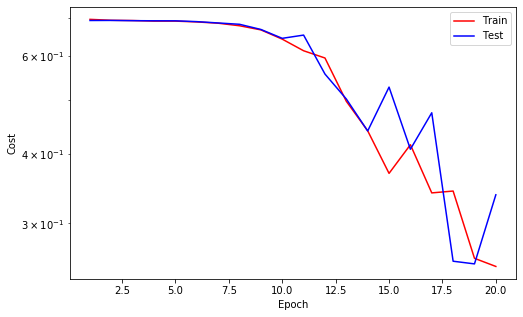

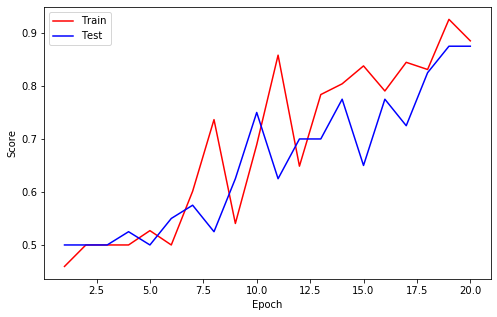

==> EarlyStop patience =  1 | Best test_score: 0.8750




Epoch    21
Train_cost  = 0.3185 | Test_cost  = 0.2599 | Train_score = 0.8446 | Test_score = 0.8750 |
==> EarlyStop patience =  2 | Best test_score: 0.8750




Epoch    22
Train_cost  = 0.2502 | Test_cost  = 0.2890 | Train_score = 0.9054 | Test_score = 0.9250 |




Epoch    23
Train_cost  = 0.2573 | Test_cost  = 0.2648 | Train_score = 0.8851 | Test_score = 0.8500 |
==> EarlyStop patience =  1 | Best test_score: 0.9250




Epoch    24
Train_cost  = 0.2593 | Test_cost  = 0.2645 | Train_score = 0.9324 | Test_score = 0.8500 |
==> EarlyStop patience =  2 | Best test_score: 0.9250




Epoch    25
Train_cost  = 0.2097 | Test_cost  = 0.3044 | Train_score = 0.9459 | Test_score = 0.8750 |
==> EarlyStop patience =  3 | Best test_score: 0.9250




Epoch    26
Train_cost  = 0.2635 | Test_cost  = 0.2635 | Train_score = 0.8919 | Test_score = 0.8750 |
==> EarlyStop patience =  4 | Best test_score: 0.9250




Epoch    27
Train_cost  = 0.2459 | Test_cost  = 0.2574 | Train_score = 0.8986 | Test_score = 0.8750 |
==> EarlyStop patience =  5 | Best test_score: 0.9250
==> Execute Early Stopping at epoch: 27 | Best test_score: 0.9250
==> Best model is saved at model


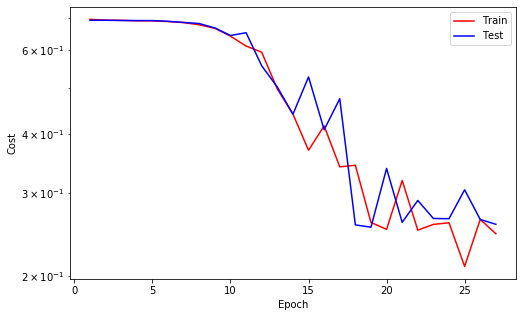

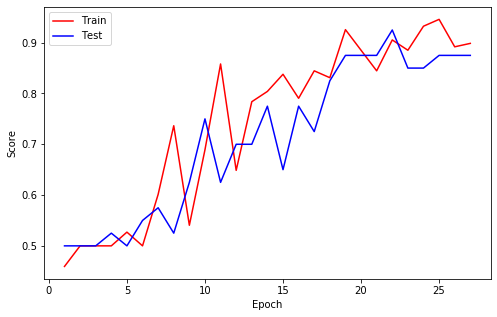

In [144]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Sanity Check

In [145]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)  
preds

tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1])

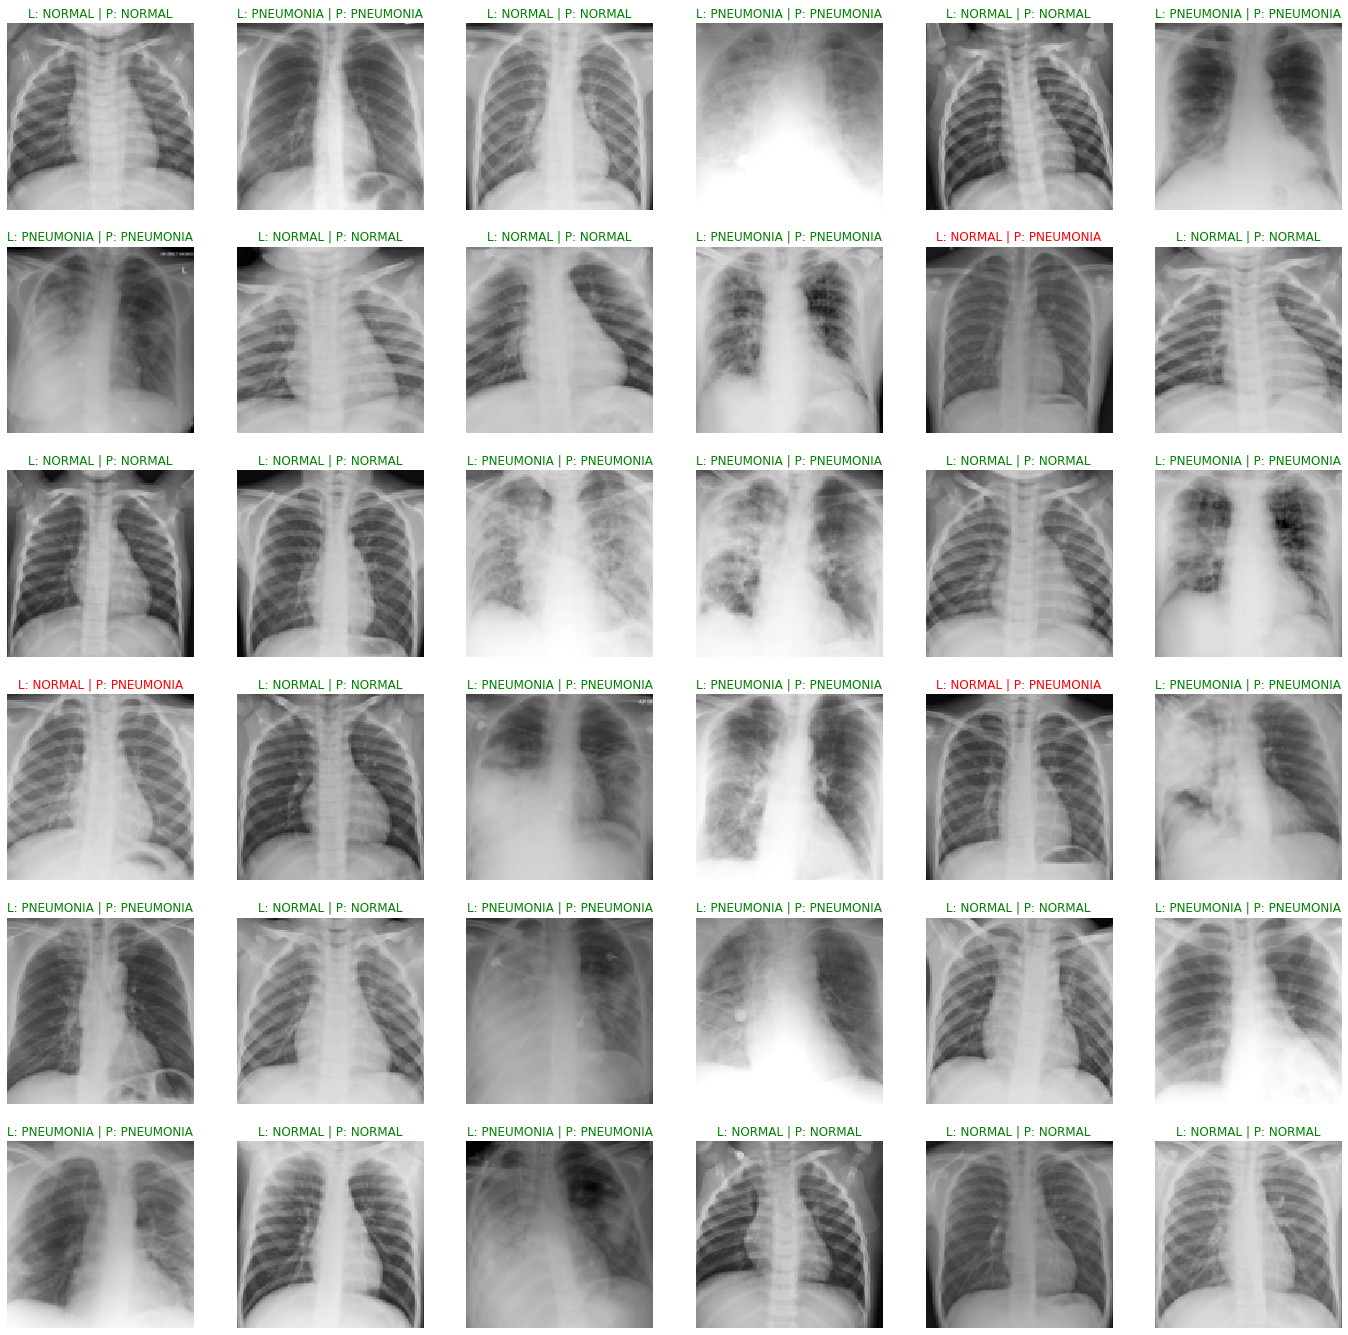

In [146]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');